<a href="https://colab.research.google.com/github/stephvp1172/deeplearningfinal/blob/main/ChatBotCode_Skahic_Palanca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Chatbot Comparison

Lejla Skahic, Stephanie Palanca


### Install/import packages

In [1]:
!pip install nltk
!pip install numpy
!pip install tensorflow

In [2]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.1 MB/s eta 0:00:00


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
pip install kaggle --upgrade

In [7]:
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [8]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Load data

In [9]:
!kaggle datasets download -d niraliivaghani/chatbot-dataset/

  0% 0.00/4.57k [00:00<?, ?B/s]
100% 4.57k/4.57k [00:00<00:00, 11.2MB/s]


In [10]:
!unzip -q chatbot-dataset.zip -d dataset-folder/

In [11]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = '/content/dataset-folder/intents.json'

intents = load_json_file(filename)

## Preprocessing

In [12]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })

    return df

df = create_df()
df

,Pattern,Tag


In [13]:
def extract_json_info(json_file, df):

    for intent in json_file['intents']:

        for pattern in intent['patterns']:

            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag

    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [14]:
print(f"Chatbot dataset has {df.shape[0]} rows and {df.shape[1]} columns")

Chatbot dataset has 405 rows and 2 columns


In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  405 non-null    object
 1   Tag      405 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB
None


In [16]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")

num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 38 classes


In [17]:
df2 = df.copy()
df2

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting
...,...,...
400,ragging history,ragging
401,ragging incidents,ragging
402,hod,hod
403,hod name,hod


In [18]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'creator',
 'name',
 'hours',
 'number',
 'course',
 'fees',
 'location',
 'hostel',
 'event',
 'document',
 'floors',
 'syllabus',
 'library',
 'infrastructure',
 'canteen',
 'menu',
 'placement',
 'ithod',
 'computerhod',
 'extchod',
 'principal',
 'sem',
 'admission',
 'scholarship',
 'facilities',
 'college intake',
 'uniform',
 'committee',
 'random',
 'swear',
 'vacation',
 'sports',
 'salutaion',
 'task',
 'ragging',
 'hod']

In [19]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [20]:
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'creator',
 3: 'name',
 4: 'hours',
 5: 'number',
 6: 'course',
 7: 'fees',
 8: 'location',
 9: 'hostel',
 10: 'event',
 11: 'document',
 12: 'floors',
 13: 'syllabus',
 14: 'library',
 15: 'infrastructure',
 16: 'canteen',
 17: 'menu',
 18: 'placement',
 19: 'ithod',
 20: 'computerhod',
 21: 'extchod',
 22: 'principal',
 23: 'sem',
 24: 'admission',
 25: 'scholarship',
 26: 'facilities',
 27: 'college intake',
 28: 'uniform',
 29: 'committee',
 30: 'random',
 31: 'swear',
 32: 'vacation',
 33: 'sports',
 34: 'salutaion',
 35: 'task',
 36: 'ragging',
 37: 'hod'}

In [21]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'creator': 2,
 'name': 3,
 'hours': 4,
 'number': 5,
 'course': 6,
 'fees': 7,
 'location': 8,
 'hostel': 9,
 'event': 10,
 'document': 11,
 'floors': 12,
 'syllabus': 13,
 'library': 14,
 'infrastructure': 15,
 'canteen': 16,
 'menu': 17,
 'placement': 18,
 'ithod': 19,
 'computerhod': 20,
 'extchod': 21,
 'principal': 22,
 'sem': 23,
 'admission': 24,
 'scholarship': 25,
 'facilities': 26,
 'college intake': 27,
 'uniform': 28,
 'committee': 29,
 'random': 30,
 'swear': 31,
 'vacation': 32,
 'sports': 33,
 'salutaion': 34,
 'task': 35,
 'ragging': 36,
 'hod': 37}

In [22]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,Hi,greeting,0
1,How are you?,greeting,0
2,Is anyone there?,greeting,0
3,Hello,greeting,0
4,Good day,greeting,0


## EDA

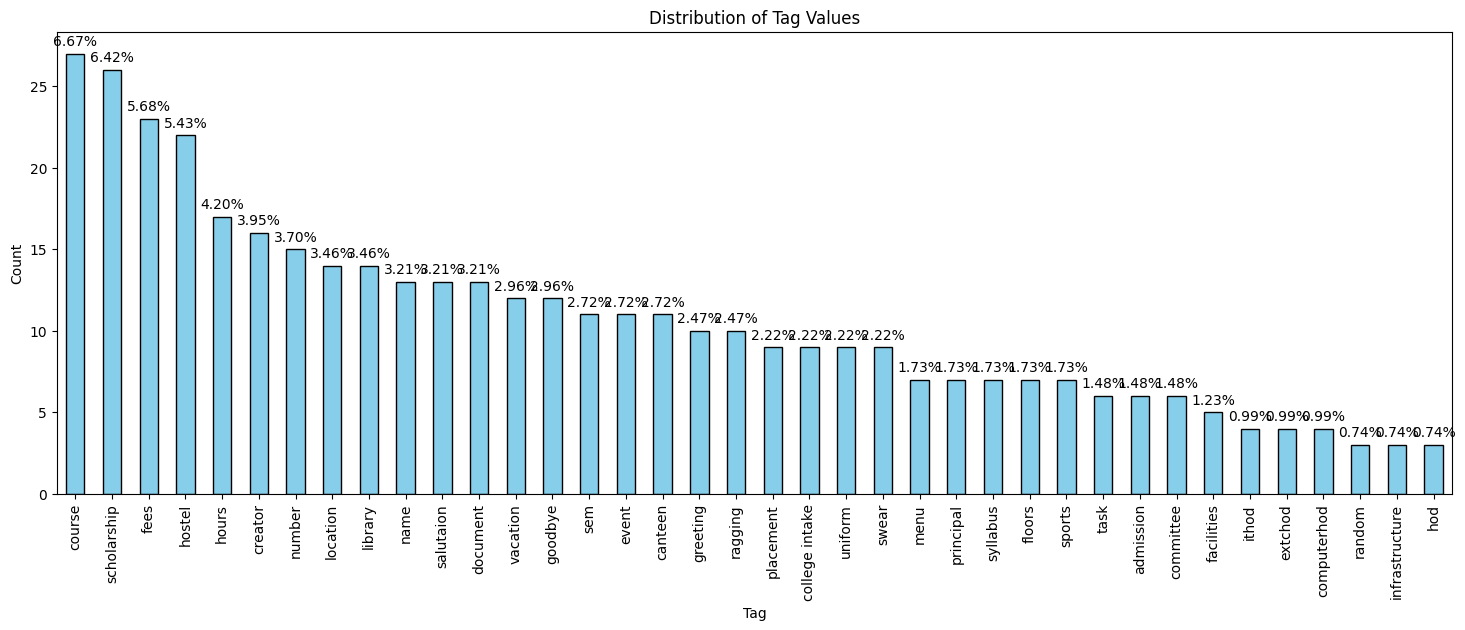

In [23]:
tag_counts = df['Tag'].value_counts()

tag_percentages = (tag_counts / len(df)) * 100

plt.figure(figsize=(18, 6))
tag_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.title('Distribution of Tag Values')

#Add percentage labels on top of the bars
for i, count in enumerate(tag_counts):
    plt.text(i, count + 0.5, f'{tag_percentages[i]:.2f}%', ha='center')


plt.show()
#this was changed from original

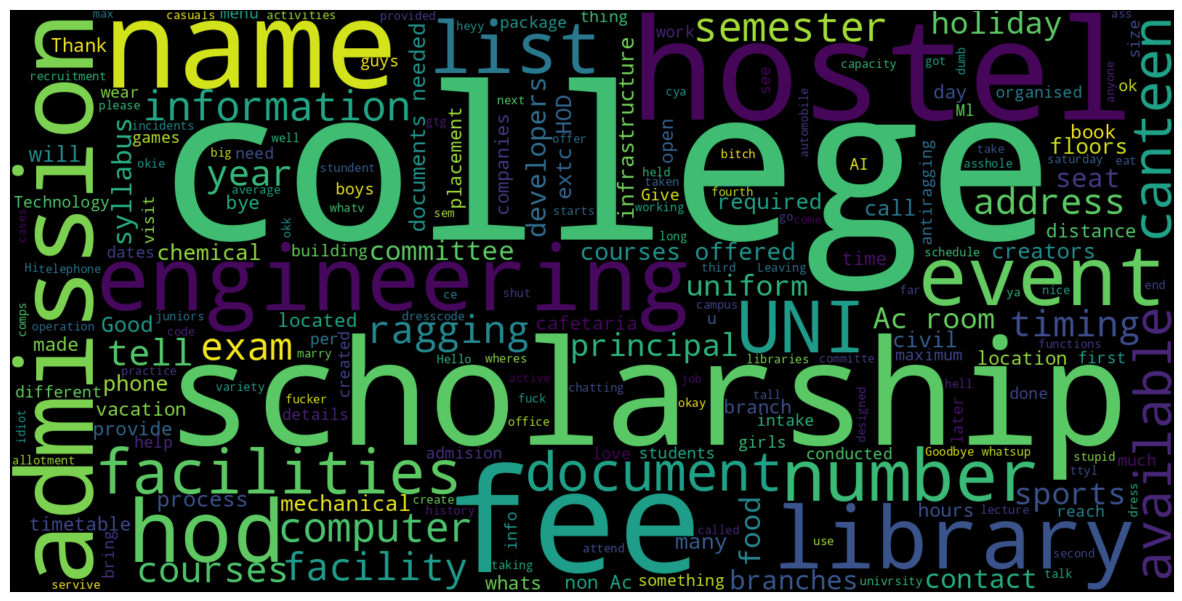

In [24]:
plt.figure(figsize=(15,10))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

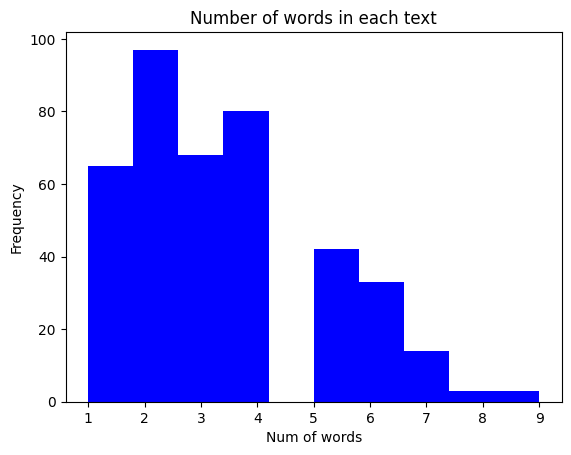

In [25]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='blue')
plt.title("Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

## Train/test split

In [26]:
X = list(df2['Pattern'])
X[:5]

['Hi', 'How are you?', 'Is anyone there?', 'Hello', 'Good day']

In [27]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

## BERT Chatbot

In [ ]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#transform data
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
full_data = tokenizer(X, truncation=True, padding=True)

In [ ]:
#build data loader
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [ ]:
fullDataLoader = DataLoader(full_data, y_test)

In [ ]:
#eval metrics
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [ ]:
#training arguments
#this was changed from original

training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=50,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=25,
    evaluation_strategy="steps",
    eval_steps=25,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
25,3.179200,2.915176,0.313725,0.186555,0.234201,0.264286
50,2.169700,1.996117,0.735294,0.633628,0.670699,0.674194
75,1.317300,1.260264,0.872549,0.824842,0.842448,0.855914
100,0.741800,0.799577,0.931373,0.938948,0.960189,0.943011
125,0.442900,0.593626,0.911765,0.917353,0.934293,0.931183
150,0.279900,0.469780,0.941176,0.944789,0.952151,0.959140
175,0.194800,0.394101,0.941176,0.944789,0.952151,0.959140
200,0.156800,0.382268,0.941176,0.944789,0.952151,0.959140
225,0.134500,0.376891,0.931373,0.935991,0.949078,0.948387
250,0.126600,0.370663,0.941176,0.944789,0.952151,0.959140


TrainOutput(global_step=250, training_loss=0.8743540000915527, metrics={'train_runtime': 55.4772, 'train_samples_per_second': 273.085, 'train_steps_per_second': 4.506, 'total_flos': 132394835374200.0, 'train_loss': 0.8743540000915527, 'epoch': 50.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.093227,0.996700,0.998509,0.998747,0.998355
test,0.370663,0.941176,0.944789,0.952151,0.959140


In [ ]:
epoch = pd.DataFrame(trainer.state.log_history).iloc[:,2].drop_duplicates()
#this was changed from original

In [ ]:
epoch = epoch.reset_index(drop=True)
#this was changed from original

In [ ]:
eval_loss = pd.DataFrame(trainer.state.log_history).iloc[:,4].dropna()
#this was changed from original

In [ ]:
eval_loss = eval_loss.reset_index(drop=True)[0:10]
#this was changed from original

In [ ]:
loss = pd.DataFrame(trainer.state.log_history).iloc[:,0].dropna()
#this was changed from original

In [ ]:
loss = loss.reset_index(drop=True)
#this was changed from original

In [ ]:
result = pd.concat([epoch, eval_loss, loss], axis=1)
#this was changed from original

In [ ]:
result
#this was changed from original

,epoch,eval_loss,loss
0,5.0,2.915176,3.1792
1,10.0,1.996117,2.1697
2,15.0,1.260264,1.3173
3,20.0,0.799577,0.7418
4,25.0,0.593626,0.4429
5,30.0,0.469780,0.2799
6,35.0,0.394101,0.1948
7,40.0,0.382268,0.1568
8,45.0,0.376891,0.1345
9,50.0,0.370663,0.1266


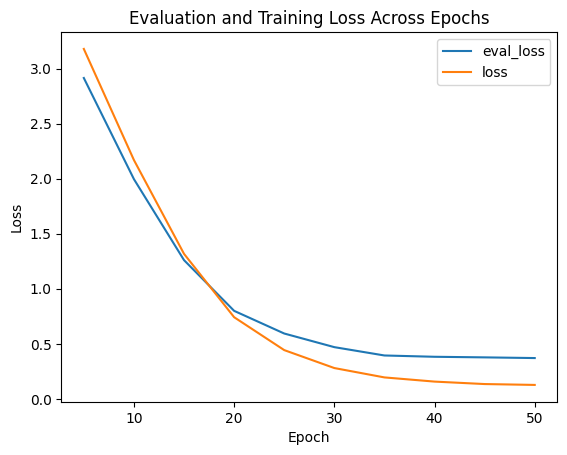

In [ ]:
plt.plot(result['epoch'], result['eval_loss'], label='eval_loss')
plt.plot(result['epoch'], result['loss'], label='loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evaluation and Training Loss Across Epochs')

# Add a legend
plt.legend()

# Show the plot
plt.show()
#this was changed from original

In [ ]:
eval_accuracy = pd.DataFrame(trainer.state.log_history).iloc[:,5].dropna()
#this was changed from original

In [ ]:
eval_accuracy = eval_accuracy.reset_index(drop=True)[0:10]
#this was changed from original

In [ ]:
result1 = pd.concat([epoch, eval_accuracy], axis=1)
#this was changed from original

In [ ]:
result1
#this was changed from original

,epoch,eval_Accuracy
0,5.0,0.313725
1,10.0,0.735294
2,15.0,0.872549
3,20.0,0.931373
4,25.0,0.911765
5,30.0,0.941176
6,35.0,0.941176
7,40.0,0.941176
8,45.0,0.931373
9,50.0,0.941176


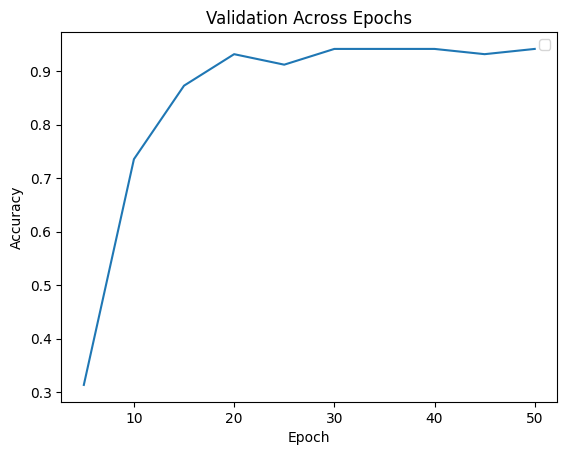

In [ ]:
plt.plot(result1['epoch'], result1['eval_Accuracy'])

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Across Epochs')

# Add a legend
plt.legend()

# Show the plot
plt.show()
#this was changed from original

In [ ]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [ ]:
model_path = "chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot/tokenizer_config.json',
 'chatbot/special_tokens_map.json',
 'chatbot/vocab.txt',
 'chatbot/added_tokens.json')

In [ ]:
!pip install xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
model_path = "chatbot"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
chatbot("Bye")
#this was changed from original

[{'label': 'goodbye', 'score': 0.9060980677604675}]

In [ ]:
def chat(chatbot):

    print("Chatbot: Hi! I am your virtual assistant! Feel free to ask me anything, and I'll do my best to provide you with answers and assistance!")
    print("Type 'quit' to exit the chat\n\n")

    text = input("User: ").strip().lower()

    while(text != 'quit'):

        score = chatbot(text)[0]['score']

        if score < 0.8:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue

        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])

        print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()

  #this was changed from original

In [ ]:
chat(chatbot)
#this was changed from original

Chatbot: Hi! I am your virtual assistant! Feel free to ask me anything, and I'll do my best to provide you with answers and assistance!
Type 'quit' to exit the chat


User: yo
Chatbot: Sorry I can't answer that


User: admission
Chatbot: Sorry I can't answer that


User: admission process
Chatbot: Sorry I can't answer that


User: scholarship
Chatbot: Many government scholarships are supported by our university. For details and updates visit <a target="_blank" href="(SCHOLARSHIP DETAILS LINK)">here</a>


User: courses
Chatbot: Our university offers Information Technology, computer Engineering, Mechanical engineering,Chemical engineering, Civil engineering and extc Engineering.


User: facilities
Chatbot: Our university's Engineering department provides fully AC Lab with internet connection, smart classroom, Auditorium, library,canteen


User: okay bye
Chatbot: Talk to you later


User: COURSES
Chatbot: Our university offers Information Technology, computer Engineering, Mechanical engin

## NTLK, TensorFlow, and Keras Chatbot

In [29]:
# Tokenize the sentences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

# Convert sentences to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
max_length = max([len(x) for x in train_sequences])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 9, 32)             8032      
                                                                 
 lstm (LSTM)                 (None, 9, 128)            82432     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

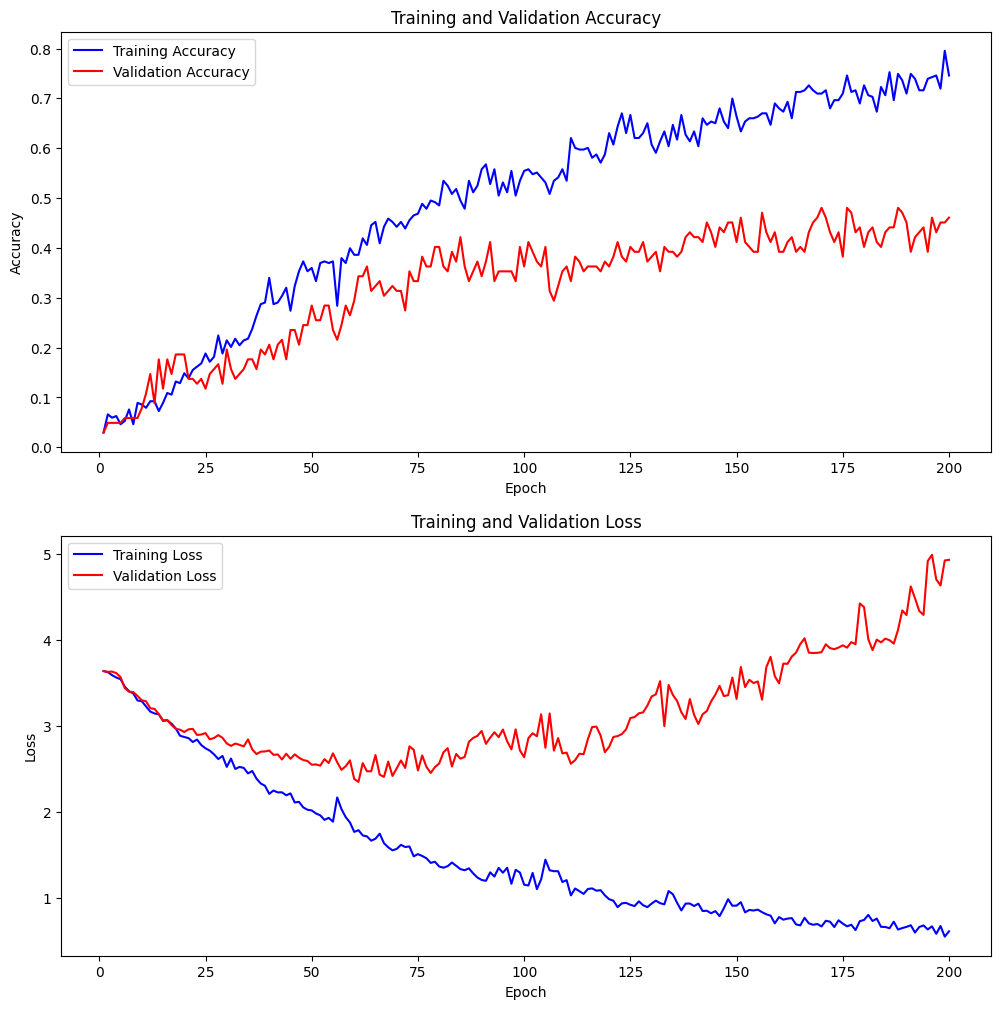

In [30]:
#Building the model
model = tf.keras.Sequential([
    # Embedding layer
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_length),

    # Adding LSTM layers
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),

    # Adding additional layers
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # drop out layer for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

#Training the model
num_epochs = 200
history = model.fit(train_padded, np.array(y_train), epochs=num_epochs, validation_data=(test_padded, np.array(y_test)))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Setting up the number of epochs as the x-axis
epochs = range(1, len(acc) + 1)

# Extracting loss data
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Setting up the number of epochs as the x-axis
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 12))

# Subplot for accuracy
plt.subplot(2, 1, 1)  #first subplot
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(2, 1, 2)  #second subplot
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [31]:
# Evaluate the model
loss, accuracy = model.evaluate(test_padded, np.array(y_test))
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Saving the model
model.save("chatbot_model.h5")

4/4 [==============================] - 0s 6ms/step - loss: 4.9268 - accuracy: 0.4608
Loss: 4.926764488220215, Accuracy: 0.46078431606292725


In [34]:
def predict_tag(sentence, tokenizer, model):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post')
    prediction = model.predict(padded)
    return id2label[np.argmax(prediction)]

# Testing model's ability to categorize inquires
predict_tag("where is the engineering building?", tokenizer, model)

1/1 [==============================] - 0s 34ms/step


'fees'

In [33]:
from tensorflow.keras.models import load_model

model = load_model("chatbot_model.h5")

#creating a prediction function
def predict_tag(sentence):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post')
    prediction = model.predict(padded)
    predicted_tag = id2label[np.argmax(prediction)]
    return predicted_tag


def get_response(tag):

    responses = {
        "greeting": "Hello! How can I help you?",
    }
    return responses.get(tag, "I'm not sure how to respond to that.")

print("Chatbot is online! Type 'quit' to exit.")

while True:
    user_input = input("You: ")
    if user_input.lower() == "quit":
        break

    tag = predict_tag(user_input)
    response = get_response(tag)
    print(f"Chatbot: {response}")

Chatbot is online! Type 'quit' to exit.
You: what time is the university open?
1/1 [==============================] - 3s 3s/step
Chatbot: I'm not sure how to respond to that.
You: what time is the library open?
1/1 [==============================] - 0s 19ms/step
Chatbot: I'm not sure how to respond to that.
You: quit
